# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a publis s3 bucket: s3://sta9760-yelpdataset/yelp-light/*business.json

# Part 1: Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install pandas and matplotlib

In [1]:
%info

In [2]:
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
6,application_1588541145487_0015,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)

  Using cached seaborn-0.10.0-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)

## Importing
Now, import the installed packages from the previous block below.

In [3]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
kiwisolver                 1.2.0
lxml                       4.4.2
matplotlib                 3.2.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pandas                     1.0.3
pip                        20.1
py-dateutil                2.2
pyparsing                  2.4.7
python-dateutil            2.8.1
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
scipy                      1.4.1
seaborn                    0.10.0
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

## Loading Data

We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [4]:
df_business = spark.read.json('s3://sta9760-yelp-reviews-datasets/*yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data
Display the number of rows and columns in our dataset.

In [5]:
print(f'Total Columns: {len(df_business.dtypes)}')
print(f'Total Rows: {df_business.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393

Display the DataFrame schema below.

In [6]:
df_business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

- business_id
- name
- city
- state
- categories

In [7]:
df_business.select('business_id','name','city','state','categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

# Part 2: Analyzing Categories
Let's now answer this question: how many unique categories are represented in this dataset?

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

- How many businesses are categorized as Active Life, for instance
- What are the top 20 most popular categories available?

## Association Table
We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [8]:
from pyspark.sql.functions import split, explode
df_business2 = df_business.withColumn('categories',explode(split('categories',', ')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [9]:
df_business2.select('business_id','categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|      categories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [10]:
from pyspark.sql.functions import col, countDistinct
df_business2.agg(countDistinct("categories")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------+
|count(DISTINCT categories)|
+--------------------------+
|                      1336|
+--------------------------+

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category
So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [11]:
df_business2.groupBy('categories').count().show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|         categories|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|       Aerial Tours|   28|
|      Skating Rinks|  104|
|  Signature Cuisine|    1|
|             Fondue|   54|
|      Data Recovery|  195|
|  Pet Waste Removal|   34|
|      Videographers|  169|
|    Pet Photography|   49|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|Private Jet Charter|   10|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```# 

In [12]:
pdf_business2 = df_business2.groupBy('categories').count().orderBy('count',ascending=False).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
pdf_business2.head(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   categories  count
0                 Restaurants  63944
1                    Shopping  34644
2                        Food  32991
3               Home Services  22487
4               Beauty & Spas  20520
5            Health & Medical  19227
6              Local Services  15783
7                  Automotive  14720
8                   Nightlife  14211
9                        Bars  12400
10  Event Planning & Services  11263
11                Active Life  10225
12               Coffee & Tea   8415
13                    Fashion   8374
14                  Fast Food   8106
15                 Sandwiches   8064
16     American (Traditional)   7596
17              Home & Garden   7331
18                Hair Salons   7303
19                      Pizza   7302

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

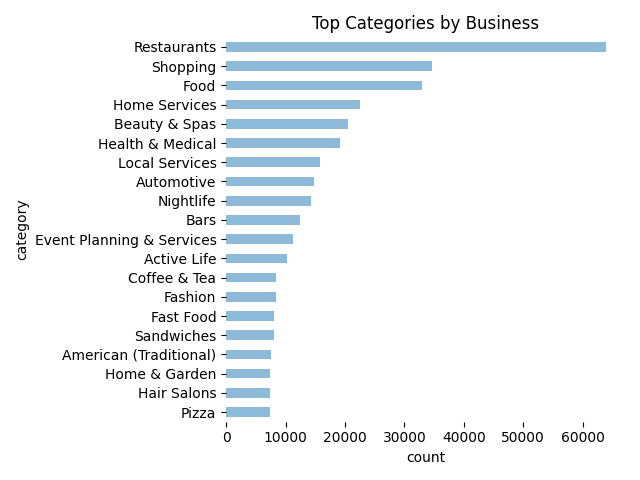

In [14]:
import matplotlib 
import matplotlib.pyplot as plt
pdf_business2.head(20).plot.barh(x='categories', y='count',legend= False, alpha=0.5)
plt.ylabel('category')
plt.xlabel('count')
plt.title('Top Categories by Business')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.box(False)
plt.show()
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [15]:
df_review = spark.read.json('s3://sta9760-yelp-reviews-datasets/*yelp_academic_dataset_review.json')
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [16]:
df_review.select('business_id','stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [17]:
from pyspark.sql import functions as F
df_review.groupBy("business_id").agg(F.mean('stars')).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [18]:
df_avg_star = df_review.groupBy("business_id").agg(F.mean('stars'))
df_join = df_business.join(df_avg_star, "business_id", "inner")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [19]:
df_join2 = df_join.select("avg(stars)","stars","name","city","state")
df_join2.orderBy("avg(stars)",ascending=False).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+---------------+-----+
|avg(stars)|stars|                name|           city|state|
+----------+-----+--------------------+---------------+-----+
|       5.0|  5.0|Diamond Finish De...|      Avon Lake|   OH|
|       5.0|  5.0|DB Mobile Notary ...|      Las Vegas|   NV|
|       5.0|  5.0|         Xoxo Lashes|North Las Vegas|   NV|
|       5.0|  5.0|          Econolight|        Phoenix|   AZ|
|       5.0|  5.0|         Beezy Booth|         Peoria|   AZ|
+----------+-----+--------------------+---------------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [20]:
df_join3= df_join2.withColumn('skew',(df_join2['avg(stars)'] - df_join2['stars']) / df_join2['stars'])
df_join3.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------+-----+--------------------+
|        avg(stars)|stars|                name|       city|state|                skew|
+------------------+-----+--------------------+-----------+-----+--------------------+
|  4.11784140969163|  4.0|Delmonico Steakhouse|  Las Vegas|   NV|0.029460352422907565|
|2.3333333333333335|  2.5|Neo-Paws Internat...|    Toronto|   ON|-0.06666666666666661|
|             4.375|  4.5| McFarling Law Group|  Las Vegas|   NV|-0.02777777777777...|
|3.3333333333333335|  3.5|Volvo of Mississauga|Mississauga|   ON|-0.04761904761904...|
|               5.0|  5.0|Andre Agassi Coll...|  Las Vegas|   NV|                 0.0|
+------------------+-----+--------------------+-----------+-----+--------------------+
only showing top 5 rows

And finally, graph it!

In [21]:
pdf_join3 = df_join3.select('skew').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

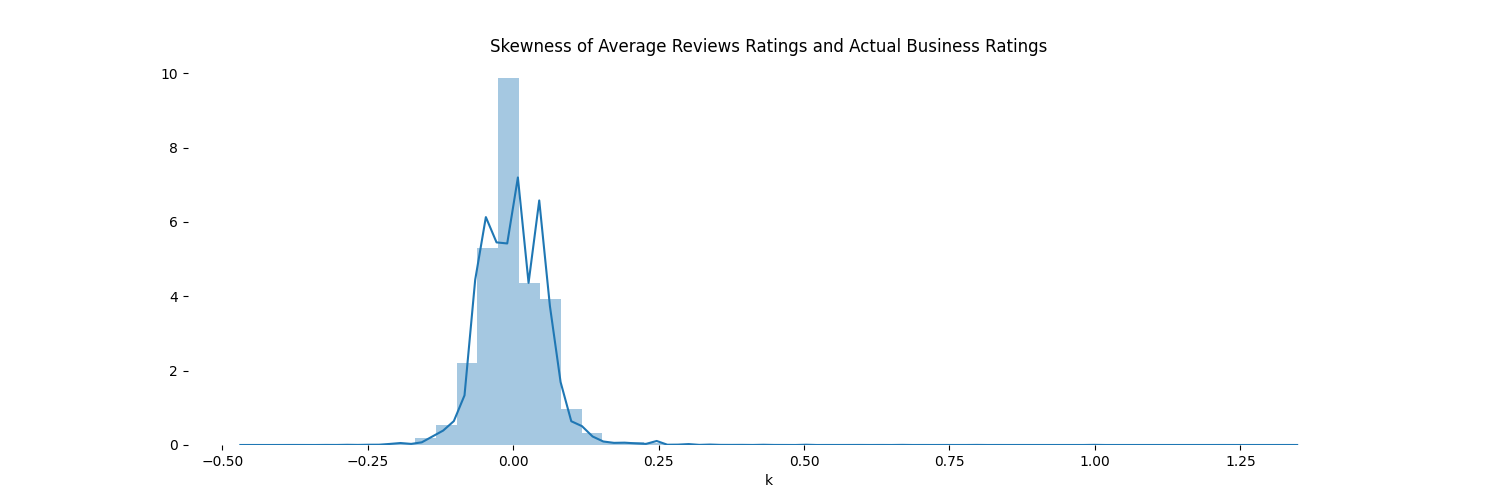

In [33]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.distplot(pdf_join3)
plt.xlabel('k')
plt.title('Skewness of Average Reviews Ratings and Actual Business Ratings')
plt.box(False)
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

Answer:
No, Yelp writter reviews skew positive. Reviewers who left a written response were more satisfied than normal.


# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

In [23]:
df_user = spark.read.json('s3://sta9760-yelp-reviews-datasets/*yelp_academic_dataset_user.json')
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [24]:
df_user.select('user_id','elite','average_stars').show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+
|             user_id|               elite|average_stars|
+--------------------+--------------------+-------------+
|ntlvfPzc8eglqvk92...|                    |         3.57|
|FOBRPlBHa3WPHFB5q...|2008,2009,2010,20...|         3.84|
|zZUnPeh2hEp0WydbA...|                2010|         3.44|
|QaELAmRcDc5TfJEyl...|                2009|         3.08|
|xvu8G900tezTzbbfq...|2009,2010,2011,20...|         4.37|
|z5_82komKV3mI4ASG...|                2007|         2.88|
|ttumcu6hWshk_EJVW...|                    |          4.0|
|f4_MRNHvN-yRn7EA8...|2011,2012,2013,20...|         3.63|
|UYACF30806j2mfbB5...|                    |         3.75|
|QG13XBbgHWydzThRB...|           2008,2009|          4.1|
+--------------------+--------------------+-------------+
only showing top 10 rows

In [25]:
#only keep elite user_id
df_elite = df_user.filter("elite != ''")
df_elite.select('user_id','elite','average_stars').show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+
|             user_id|               elite|average_stars|
+--------------------+--------------------+-------------+
|FOBRPlBHa3WPHFB5q...|2008,2009,2010,20...|         3.84|
|zZUnPeh2hEp0WydbA...|                2010|         3.44|
|QaELAmRcDc5TfJEyl...|                2009|         3.08|
|xvu8G900tezTzbbfq...|2009,2010,2011,20...|         4.37|
|z5_82komKV3mI4ASG...|                2007|         2.88|
|f4_MRNHvN-yRn7EA8...|2011,2012,2013,20...|         3.63|
|QG13XBbgHWydzThRB...|           2008,2009|          4.1|
|I_6wY8_RsewziNnKh...|2010,2011,2012,20...|         3.63|
|q-v8elVPvKz0KvK69...|2011,2012,2013,20...|         3.37|
|1WBxJ2r3A2QYfRSEz...|2010,2011,2012,20...|         3.82|
+--------------------+--------------------+-------------+
only showing top 10 rows

In [26]:
#join elite user dataframe and review dataframe
df = df_elite.join(df_review, "user_id", "inner").select("user_id","average_stars","business_id")
df.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+--------------------+
|             user_id|average_stars|         business_id|
+--------------------+-------------+--------------------+
|-1KKYzibGPyUX-Mwk...|          4.0|L772e6l2Yd0DJEyCB...|
|-3i9bhfvrM3F1wsC9...|          4.1|DYuOxkW4DtlJsTHdx...|
|-3i9bhfvrM3F1wsC9...|          4.1|ghpFh6XpH1TYZhjAG...|
|-3i9bhfvrM3F1wsC9...|          4.1|5iSmZO0SrKU6EoXK_...|
|-3i9bhfvrM3F1wsC9...|          4.1|yNVcnSaMSrTmjJBMr...|
|-3i9bhfvrM3F1wsC9...|          4.1|GtHu9uGXpn7Jg_Z7v...|
|-3i9bhfvrM3F1wsC9...|          4.1|pSQFynH1VxkfSmehR...|
|-3i9bhfvrM3F1wsC9...|          4.1|OARQDsxyoGnnX2FfS...|
|-3i9bhfvrM3F1wsC9...|          4.1|bvow46stEejfxnnqE...|
|-3i9bhfvrM3F1wsC9...|          4.1|Gaq3S9lmjXVcuDCZ8...|
+--------------------+-------------+--------------------+
only showing top 10 rows

In [27]:
#continue to join with business dataframe
df2 = df.join(df_business,"business_id","inner").select("business_id","average_stars","stars")
df2.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+-----+
|         business_id|average_stars|stars|
+--------------------+-------------+-----+
|L772e6l2Yd0DJEyCB...|          4.0|  3.0|
|DYuOxkW4DtlJsTHdx...|          4.1|  4.0|
|OARQDsxyoGnnX2FfS...|          4.1|  4.5|
|bvow46stEejfxnnqE...|          4.1|  4.0|
|Gaq3S9lmjXVcuDCZ8...|          4.1|  3.5|
|ZGU2--DiLxf7enO3I...|          4.1|  3.5|
|939j88ceB05Te3D7k...|          4.1|  3.5|
|ghpFh6XpH1TYZhjAG...|          4.1|  4.0|
|BLIJ-p5wYuAhw6Pp6...|          4.1|  3.0|
|5iSmZO0SrKU6EoXK_...|          4.1|  2.5|
+--------------------+-------------+-----+
only showing top 10 rows

In [28]:
df3= df2.withColumn('skew',(df2['average_stars'] - df2['stars']) / df2['stars'])
df3.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+-----+-------------------+
|         business_id|average_stars|stars|               skew|
+--------------------+-------------+-----+-------------------+
|L772e6l2Yd0DJEyCB...|          4.0|  3.0| 0.3333333333333333|
|939j88ceB05Te3D7k...|          4.1|  3.5|0.17142857142857132|
|pSQFynH1VxkfSmehR...|          4.1|  4.0|0.02499999999999991|
|ZGU2--DiLxf7enO3I...|          4.1|  3.5|0.17142857142857132|
|V9klA6JGT6Fz2UpVP...|          4.1|  2.5| 0.6399999999999999|
|DYuOxkW4DtlJsTHdx...|          4.1|  4.0|0.02499999999999991|
|ghpFh6XpH1TYZhjAG...|          4.1|  4.0|0.02499999999999991|
|BLIJ-p5wYuAhw6Pp6...|          4.1|  3.0|0.36666666666666653|
|5iSmZO0SrKU6EoXK_...|          4.1|  2.5| 0.6399999999999999|
|yNVcnSaMSrTmjJBMr...|          4.1|  3.5|0.17142857142857132|
+--------------------+-------------+-----+-------------------+
only showing top 10 rows

In [31]:
pdf3 = df3.select('skew').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

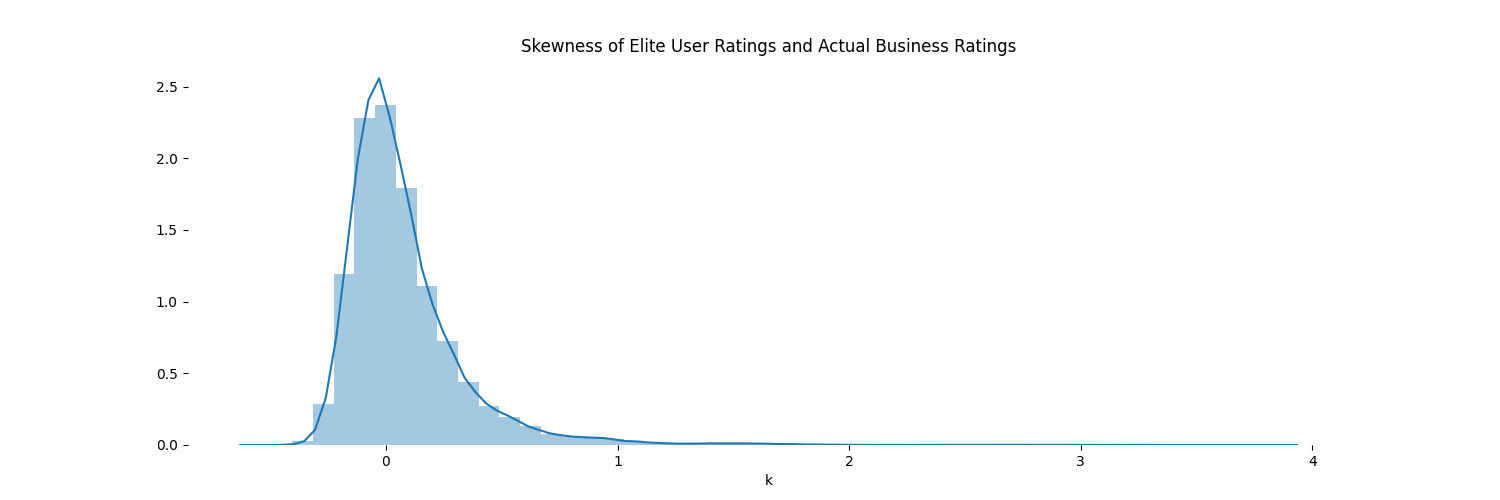

In [32]:
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
sns.distplot(pdf3)
plt.xlabel('k')
plt.title('Skewness of Elite User Ratings and Actual Business Ratings')
plt.box(False)
%matplot plt